# g1d Example

Here we demonstrate the use of the gq adjoint method on the g1d problem,
proposed in https://arxiv.org/abs/1904.01681.

The aim is to map [-1, 1] to [1, -1] with a Neural ODE. The aim of the problem
is to show augmenting the state is needed to learn this mapping, since
trajectories cannot cross. We use it to demonstrate the use of the gq adjoint
and the speed improvements during training when a large number of parameters are
used.

In [1]:
import time
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch_gq_adjoint import odeint, odeint_adjoint, odeint_adjoint_gq

## Set up data.

In [2]:
input = torch.tensor([[1.0], [-1.0]]).float()
target = torch.tensor([[-1.0], [1.0]]).float()

## Set up Augmentation Helper Functions and Neural Network

In [3]:
# Set up augmentation helper functions.
def augment_dimensions(input, num_dims):
    aug_zeros = torch.zeros((*input.shape[:-1], num_dims))
    return torch.cat((input, aug_zeros), dim=-1)


def remove_augmentation(input, num_dims):
    return input[..., :-num_dims]


# Set up Neural Network for Neural ODE.
class NeuralODEDynamicsFunc(nn.Module):

    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, in_dim)
        self.activation = nn.Softplus()
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.activation(self.fc1(x))
        out = self.activation(self.fc2(out))
        out = self.fc3(out)
        return out

## Constants for the problem

In [4]:
num_aug = 3
num_hidden = 3000
lr = 0.0001
num_epochs = 200
times = torch.tensor([0.0, 1.0]).float()
print_every = 10

## Create Three Copies of the Same Starting Model

In [5]:
base_model = NeuralODEDynamicsFunc(1+num_aug, num_hidden)
direct_model = copy.deepcopy(base_model)
adjoint_model = copy.deepcopy(base_model)
gq_model = copy.deepcopy(base_model)

## Train with Adjoint GQ

In [6]:
optimizer = torch.optim.Adam(gq_model.parameters(), lr=lr)
gq_times = np.empty(num_epochs)
gq_losses = np.empty(num_epochs)

for epoch in range(1, num_epochs+1):
    start_time = time.time()
    optimizer.zero_grad()
    x = augment_dimensions(input, num_aug)
    out = odeint_adjoint_gq(gq_model, x, times, method="dopri5", atol=1e-3, rtol=1e-3, gtol=0.1)[-1]
    out = remove_augmentation(out, num_aug)
    loss = torch.mean((out - target)**2)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    epoch_time = end_time - start_time
    gq_times[epoch-1] = epoch_time
    gq_losses[epoch-1] = loss.item()
    
    if epoch % print_every == 0:
        avg_loss = np.mean(gq_losses[epoch-print_every:epoch])
        avg_time = np.mean(gq_times[epoch-print_every:epoch])
        print(f"Epochs {epoch-print_every}:{epoch}, Average MSE: {avg_loss:.4e}, Average Epoch Time: {avg_time:.4f}")

Epochs 0:10, Average MSE: 1.9276e+00, Average Epoch Time: 0.3675
Epochs 10:20, Average MSE: 1.0759e+00, Average Epoch Time: 0.4580
Epochs 20:30, Average MSE: 1.0019e+00, Average Epoch Time: 0.5217
Epochs 30:40, Average MSE: 8.8609e-01, Average Epoch Time: 0.6176
Epochs 40:50, Average MSE: 5.3120e-01, Average Epoch Time: 0.5486
Epochs 50:60, Average MSE: 2.9223e-01, Average Epoch Time: 0.5075
Epochs 60:70, Average MSE: 2.3931e-01, Average Epoch Time: 0.5094
Epochs 70:80, Average MSE: 4.4423e-02, Average Epoch Time: 0.4197
Epochs 80:90, Average MSE: 2.3627e-02, Average Epoch Time: 0.4029
Epochs 90:100, Average MSE: 8.6448e-03, Average Epoch Time: 0.4129
Epochs 100:110, Average MSE: 1.9823e-03, Average Epoch Time: 0.4456
Epochs 110:120, Average MSE: 9.5567e-04, Average Epoch Time: 0.4496
Epochs 120:130, Average MSE: 3.9464e-04, Average Epoch Time: 0.4111
Epochs 130:140, Average MSE: 1.0880e-04, Average Epoch Time: 0.4564
Epochs 140:150, Average MSE: 3.4618e-05, Average Epoch Time: 0.4593


## Train with Adjoint ODE

In [7]:
optimizer = torch.optim.Adam(adjoint_model.parameters(), lr=lr)
adj_times = np.empty(num_epochs)
adj_losses = np.empty(num_epochs)

for epoch in range(1, num_epochs+1):
    start_time = time.time()
    optimizer.zero_grad()
    x = augment_dimensions(input, num_aug)
    out = odeint_adjoint(adjoint_model, x, times, method="dopri5", atol=1e-3, rtol=1e-3)[-1]
    out = remove_augmentation(out, num_aug)
    loss = torch.mean((out - target)**2)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    epoch_time = end_time - start_time
    adj_times[epoch-1] = epoch_time
    adj_losses[epoch-1] = loss.item()
    
    if epoch % print_every == 0:
        avg_loss = np.mean(adj_losses[epoch-print_every:epoch])
        avg_time = np.mean(adj_times[epoch-print_every:epoch])
        print(f"Epochs {epoch-print_every}:{epoch}, Average MSE: {avg_loss:.4e}, Average Epoch Time: {avg_time:.4f}")

Epochs 0:10, Average MSE: 1.9271e+00, Average Epoch Time: 2.4140
Epochs 10:20, Average MSE: 1.0756e+00, Average Epoch Time: 3.8014
Epochs 20:30, Average MSE: 1.0023e+00, Average Epoch Time: 4.0876
Epochs 30:40, Average MSE: 8.8993e-01, Average Epoch Time: 4.5726
Epochs 40:50, Average MSE: 5.9806e-01, Average Epoch Time: 3.8556
Epochs 50:60, Average MSE: 3.9195e-01, Average Epoch Time: 3.7870
Epochs 60:70, Average MSE: 3.7209e-01, Average Epoch Time: 3.6453
Epochs 70:80, Average MSE: 1.3549e-01, Average Epoch Time: 3.3942
Epochs 80:90, Average MSE: 3.3523e-02, Average Epoch Time: 2.8737
Epochs 90:100, Average MSE: 9.4142e-03, Average Epoch Time: 2.9969
Epochs 100:110, Average MSE: 5.9912e-03, Average Epoch Time: 2.9991
Epochs 110:120, Average MSE: 1.4845e-03, Average Epoch Time: 2.9579
Epochs 120:130, Average MSE: 4.7653e-04, Average Epoch Time: 3.1217
Epochs 130:140, Average MSE: 2.6458e-04, Average Epoch Time: 3.2243
Epochs 140:150, Average MSE: 6.9055e-05, Average Epoch Time: 3.4974


## Train with Direct Backprop

In [8]:
optimizer = torch.optim.Adam(direct_model.parameters(), lr=lr)
dir_times = np.empty(num_epochs)
dir_losses = np.empty(num_epochs)

for epoch in range(1, num_epochs+1):
    start_time = time.time()
    optimizer.zero_grad()
    x = augment_dimensions(input, num_aug)
    out = odeint(direct_model, x, times, method="dopri5", atol=1e-3, rtol=1e-3)[-1]
    out = remove_augmentation(out, num_aug)
    loss = torch.mean((out - target)**2)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    epoch_time = end_time - start_time
    dir_times[epoch-1] = epoch_time
    dir_losses[epoch-1] = loss.item()
    
    if epoch % print_every == 0:
        avg_loss = np.mean(dir_losses[epoch-print_every:epoch])
        avg_time = np.mean(dir_times[epoch-print_every:epoch])
        print(f"Epochs {epoch-print_every}:{epoch}, Average MSE: {avg_loss:.4e}, Average Epoch Time: {avg_time:.4f}")

Epochs 0:10, Average MSE: 1.9277e+00, Average Epoch Time: 0.4226
Epochs 10:20, Average MSE: 1.0764e+00, Average Epoch Time: 0.5679
Epochs 20:30, Average MSE: 1.0020e+00, Average Epoch Time: 0.5828
Epochs 30:40, Average MSE: 8.8657e-01, Average Epoch Time: 0.7022
Epochs 40:50, Average MSE: 5.5269e-01, Average Epoch Time: 0.6326
Epochs 50:60, Average MSE: 3.0401e-01, Average Epoch Time: 0.6368
Epochs 60:70, Average MSE: 2.7442e-01, Average Epoch Time: 0.6481
Epochs 70:80, Average MSE: 5.7178e-02, Average Epoch Time: 0.5088
Epochs 80:90, Average MSE: 2.8004e-02, Average Epoch Time: 0.5136
Epochs 90:100, Average MSE: 8.5436e-03, Average Epoch Time: 0.5048
Epochs 100:110, Average MSE: 2.3990e-03, Average Epoch Time: 0.5380
Epochs 110:120, Average MSE: 1.2869e-03, Average Epoch Time: 0.5164
Epochs 120:130, Average MSE: 4.2976e-04, Average Epoch Time: 0.5081
Epochs 130:140, Average MSE: 1.1224e-04, Average Epoch Time: 0.5804
Epochs 140:150, Average MSE: 4.7066e-05, Average Epoch Time: 0.4963


## Print and Plot Final Results

In [9]:
print(f"Total Training Times \n\nDirect: {np.cumsum(dir_times)[-1]:.3f} s\nAdjoint: {np.cumsum(adj_times)[-1]:.3f} s\nGQ: {np.cumsum(gq_times)[-1]:.3f} s")

Total Training Times 

Direct: 109.884 s
Adjoint: 692.117 s
GQ: 92.931 s


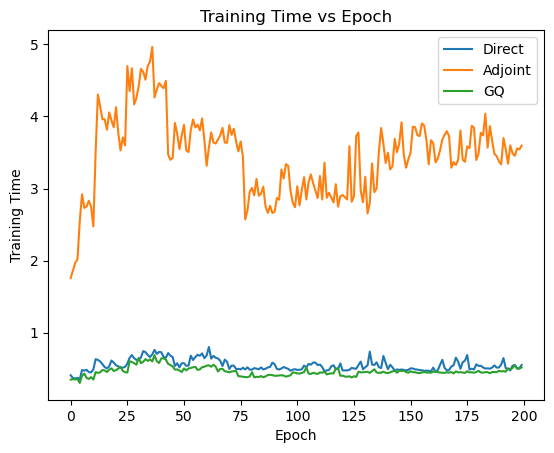

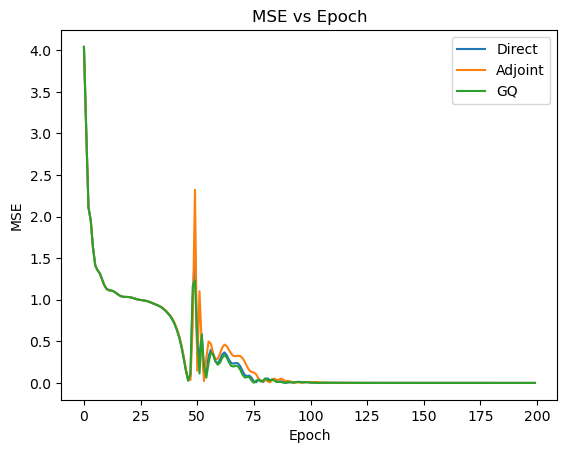

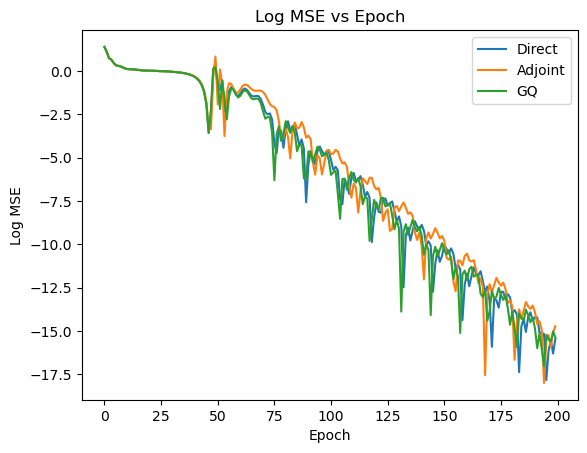

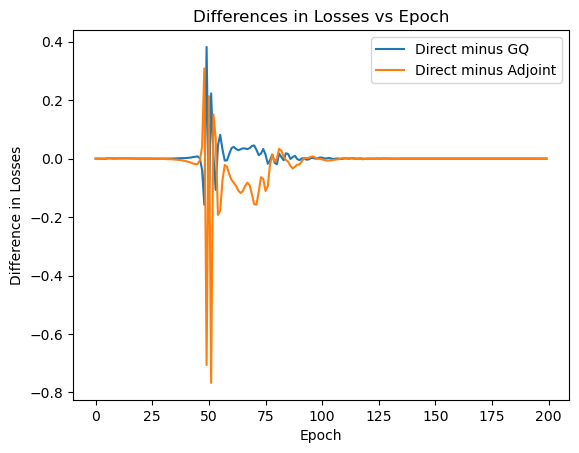

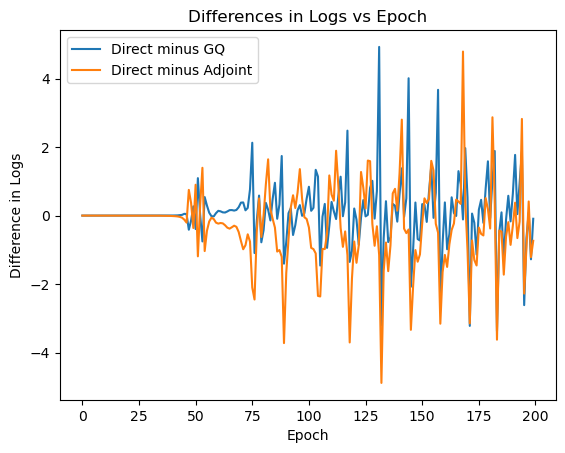

In [10]:
epochs = np.arange(num_epochs)

plt.figure()
plt.plot(epochs, dir_times, label="Direct")
plt.plot(epochs, adj_times, label="Adjoint")
plt.plot(epochs, gq_times, label="GQ")
plt.title("Training Time vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Time")
plt.legend()

plt.figure()
plt.plot(epochs, dir_losses, label="Direct")
plt.plot(epochs, adj_losses, label="Adjoint")
plt.plot(epochs, gq_losses, label="GQ")
plt.title("MSE vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

plt.figure()
plt.plot(epochs, np.log(dir_losses), label="Direct")
plt.plot(epochs, np.log(adj_losses), label="Adjoint")
plt.plot(epochs, np.log(gq_losses), label="GQ")
plt.title("Log MSE vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Log MSE")
plt.legend()

plt.figure()
plt.plot(epochs, dir_losses-gq_losses, label="Direct minus GQ")
plt.plot(epochs, dir_losses-adj_losses, label="Direct minus Adjoint")
plt.title("Differences in Losses vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Difference in Losses")
plt.legend()

plt.figure()
plt.plot(epochs, np.log(dir_losses)-np.log(gq_losses), label="Direct minus GQ")
plt.plot(epochs, np.log(dir_losses)-np.log(adj_losses), label="Direct minus Adjoint")
plt.title("Differences in Logs vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Difference in Logs")
plt.legend()

As we can see, when we have a relatively small state but many parameters, the
adjoint method trains slowly, since every function evaluation in the backwards ODE
solve requries carrying a clunky term given by $a_z^T \frac{\partial f}{\partial \theta}$.
However this is not the case for the direct or gq methods. So we see those methods
are much faster than the adjoint method in this scenario.

We also plot the differences in losses when we start at the same model, to show the
gradients being calculated approximately match, and all models are able to train.

However we see this effect reduced for large states and small models, so the method
should be used where appropriate.